In [129]:
%matplotlib inline
import pdb
import matplotlib.pyplot as plt

from zigzag import *
from oanda_api import OandaAPI
import pandas as pd

# Using data from Zigzag notebook
This section illustrates the usage of the Zigzag module using the example given in the Zigzag documentation at:
https://github.com/jbn/ZigZag/blob/master/zigzag_demo.ipynb

In [130]:
# This is not nessessary to use zigzag. It's only here so that
# this example is reproducible.
np.random.seed(1997)

In [131]:
X = np.cumprod(1 + np.random.randn(100) * 0.01)
pivots = peak_valley_pivots(X, 0.03, -0.03)

In [132]:
def plot_pivots(X, pivots):
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

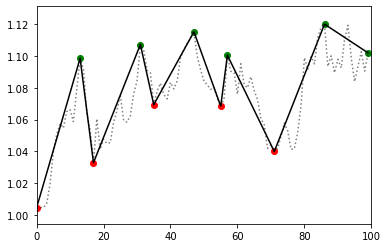

In [133]:
plot_pivots(X, pivots)

In [134]:
modes = pivots_to_modes(pivots)
print(modes)

[-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


Where segments of -1 means segments of downtrending prices, when there is a flip in the sign (from -1 to 1 or 1 to -1) correspond to the pivot points 

In [135]:
compute_segment_returns(X, pivots)

array([ 0.09370263, -0.05981991,  0.07204542, -0.03419711,  0.04289563,
       -0.04197655,  0.03001853, -0.05506552,  0.07707074, -0.016124  ])

In [136]:
X[pivots != 0]

array([1.0044464 , 1.09856567, 1.03284958, 1.10726166, 1.06939652,
       1.11526895, 1.0684538 , 1.10052722, 1.03992611, 1.12007399,
       1.10201391])

# Using FOREX data

In [137]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='EUR_AUD',
               granularity='D',
               alignmentTimezone='Europe/London')

oanda.run(start='2016-05-30T22:00:00',
          end='2016-08-16T22:00:00')

With the invocation above we are getting candle information, more specifically we get the closeAsk prices and the datetime for each of the fetched candles:

In [138]:
close_prices=[]
datetimes=[]
for c in oanda.fetch_candleset():
    close_prices.append(c.closeAsk)
    datetimes.append(c.time)

We can use the `peak_valley_pivots` function in order to identify where the peaks and valleys are:

In [139]:
pivots = peak_valley_pivots(np.array(close_prices), 0.05, -0.05)
print(pivots)

[-1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1]


Pivots will be 1 when there is a peak and -1 when there is a valley.

Next thing is to plot the pivots:

In [140]:
def plot_pivots(X, pivots):
    plt.xlim(0, len(X)) # prepare the X-axis
    plt.ylim(X.min()*0.99, X.max()*1.01) # prepare the Y-axis
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

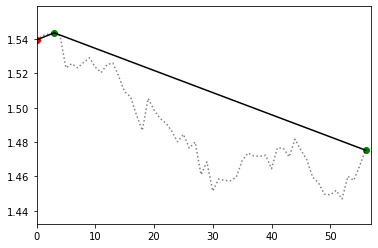

In [141]:
plot_pivots(np.array(close_prices), pivots)

In [142]:
modes = pivots_to_modes(pivots)

In [143]:
print(modes)

[-1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [144]:
pd.Series(np.array(close_prices)).pct_change().groupby(modes).describe().unstack()

count  -1    53.000000
        1     3.000000
mean   -1    -0.000841
        1     0.000891
std    -1     0.005190
        1     0.000615
min    -1    -0.012838
        1     0.000473
25%    -1    -0.004225
        1     0.000538
50%    -1    -0.001174
        1     0.000603
75%    -1     0.002088
        1     0.001100
max    -1     0.012530
        1     0.001598
dtype: float64

In [145]:
compute_segment_returns(np.array(close_prices), pivots)

array([ 0.00267612, -0.04429732])

Let's get the prices for pivot points:

In [146]:
np.array(close_prices)[pivots != 0]

array([1.53954, 1.54366, 1.47528])

Finally, let's get the datetime for the init of the trend, which will be the first peak before the last peak for the down trend:

In [147]:
np.array(datetimes)[pivots == 1][-2]

datetime.datetime(2016, 6, 2, 21, 0)

## Extending the period
Let's extend the period of time for which we have data

In [148]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='EUR_AUD',
               granularity='D',
               alignmentTimezone='Europe/London')

oanda.run(start='2016-04-20T22:00:00',
          end='2016-08-16T22:00:00')

In [149]:
close_prices=[]
datetimes=[]
for c in oanda.fetch_candleset():
    close_prices.append(c.closeAsk)
    datetimes.append(c.time)

In [150]:
pivots = peak_valley_pivots(np.array(close_prices), 0.05, -0.05)
print(pivots)

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1]


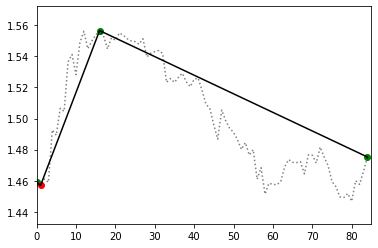

In [151]:
plot_pivots(np.array(close_prices), pivots)

Again, the first peak before the last peak for the down trend will be the init of the trend:

In [152]:
np.array(datetimes)[pivots == 1][-2]

datetime.datetime(2016, 5, 12, 21, 0)

## Extending the period 1
Let's extend the period even more

In [153]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='EUR_AUD',
               granularity='D',
               alignmentTimezone='Europe/London')

oanda.run(start='2015-12-23T22:00:00',
          end='2016-08-16T22:00:00')

In [154]:
close_prices=[]
datetimes=[]
for c in oanda.fetch_candleset():
    close_prices.append(c.closeAsk)
    datetimes.append(c.time)

In [155]:
pivots = peak_valley_pivots(np.array(close_prices), 0.05, -0.05)
print(pivots)

[ 1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]


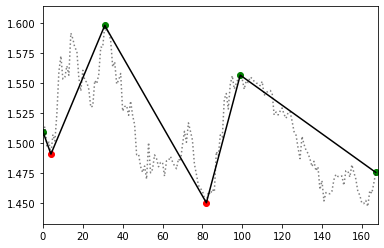

In [156]:
plot_pivots(np.array(close_prices), pivots)

Again, the first peak before the last peak for the down trend will be the init of the trend:

In [157]:
np.array(datetimes)[pivots == 1][-2]

datetime.datetime(2016, 5, 12, 21, 0)

## Let's try now with an up trend

In [158]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='GBP_AUD',
               granularity='D',
               alignmentTimezone='Europe/London')

oanda.run(start='2013-02-20T22:00:00',
          end='2013-10-01T22:00:00')

In [159]:
close_prices=[]
datetimes=[]
for c in oanda.fetch_candleset():
    close_prices.append(c.closeAsk)
    datetimes.append(c.time)

In [160]:
pivots = peak_valley_pivots(np.array(close_prices), 0.05, -0.05)
print(pivots)

[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]


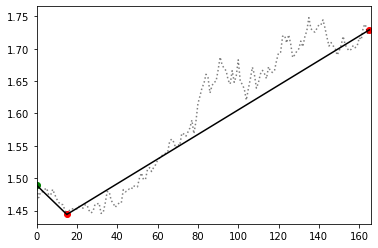

In [161]:
plot_pivots(np.array(close_prices), pivots)

Again, the first valley before the last valley for the up trend will be the init of the trend:

In [162]:
np.array(datetimes)[pivots == -1][-2]

datetime.datetime(2013, 3, 11, 21, 0)

## Extending the period 
Let's extend the period

In [163]:
oanda=OandaAPI(url='https://api-fxtrade.oanda.com/v1/candles?',
               instrument='GBP_AUD',
               granularity='D',
               alignmentTimezone='Europe/London')

oanda.run(start='2012-02-13T22:00:00',
          end='2013-10-01T22:00:00')

In [164]:
close_prices=[]
datetimes=[]
for c in oanda.fetch_candleset():
    close_prices.append(c.closeAsk)
    datetimes.append(c.time)

In [166]:
pivots = peak_valley_pivots(np.array(close_prices), 0.05, -0.05)
print(pivots)

[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

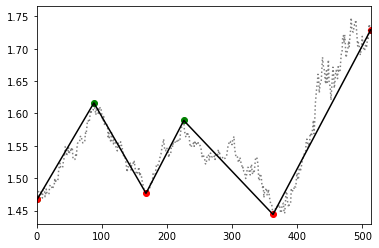

In [167]:
plot_pivots(np.array(close_prices), pivots)

Again, the first peak before the last peak for the down trend will be the init of the trend:

In [169]:
np.array(datetimes)[pivots == -1][-2]

datetime.datetime(2013, 3, 11, 21, 0)